# 7).  Plot Iono Delay computed from dual frequency measures.
###3 Stations : Low, Medium, High latitudes. Two Cases:
<p>Jan 01-31 2009 (low solar activity)    Days 1-7  & May 01-31 2014 (high solar activity)  Days 121-127
<br>Plot 1 week during the month, compute iono delay prediction error metrics per hour of day. </p>
Estaciones Canada (flin), Madrid (madr), Galapagos (glps)
<br>- Compute Iono delay with code or phase:
<img  src="ionofreecombination.png">

In [428]:
import numpy as np
import gpstk
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline


def compute_ionodelay(nfiles,ofiles): #one week data
    for i in range(len(nfiles)):  
        oheader,odata=gpstk.readRinex3Obs(ofiles[i],strict=True) 
        nheader,ndata=gpstk.readRinex3Nav(nfiles[i])
        f1=gpstk.L1_FREQ_GPS
        f2=gpstk.L2_FREQ_GPS
        Id_code=[] #delay en codigo
        Id_phase=[] #delay en fase
        to,l,p=[],[],[]  # medidas corregidas 
        for observation in odata:
            obs_types = np.array([i for i in oheader.R2ObsTypes])
            if "P1" and "P2" and "L1" and "L2" in obs_types:
                P1_idx = np.where(obs_types=="P1")[0][0]
                P2_idx = np.where(obs_types=="P2")[0][0]
                L1_idx = np.where(obs_types=="L1")[0][0]
                L2_idx = np.where(obs_types=="L2")[0][0]
                sats=[satID for satID, datumList in observation.obs.iteritems() if str(satID).split()[0]=="GPS" ] 
                time=observation.time
                for sat in sats:
                    R1=observation.getObs(sat, P1_idx).data 
                    R2=observation.getObs(sat, P2_idx).data
                    L1=observation.getObs(sat, L1_idx).data
                    L2=observation.getObs(sat, L2_idx).data
                    
                    # #Compute iono-delay on phase and code
                    alfa=1/((f1**2/f2**2)-1)
                    iono_delay_c=alfa*(R2-R1)
                    Id_code.append(iono_delay_c)
                    iono_delay_p=alfa*(L2-L1)
                    Id_phase.append(iono_delay_p)
                    
                    # #delayfree code and phase
                    R=(((f1**2)*R1)-((f2**2)*R2))/(f1**2-f2**2)
                    L=(((f1**2)*L1)-((f2**2)*L2))/(f1**2-f2**2)
                    p.append(R)
                    l.append(L)
                    
                    to.append(gpstk.GPSWeekSecond(time).sow)
                    #compute error metric for an specific hour
                    # pseudorango en ambas frecuencias-verdadero rango
                    #hourofday=gp
                    
                    break #solo tomo un satelite
            else:
                print "Needs both L1 and L2 frequencies to compute delay"
                break
    
    return p,l,to,Id_code,Id_phase
       


In [429]:
def plot_delay(p,l,to,Idc,Idp):
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.title("Iono-delay on code")
    plt.scatter(to,Idc, s=1, alpha=.5, color="green",marker=".",label="Code")
    plt.xlabel("Time of week [seconds]")
    plt.ylabel("Delay [meters]")
    plt.subplot(2,2,2)
    plt.title("Iono-delay on phase")
    plt.scatter(to,Idp, s=1, alpha=.5, color="red",marker=".",label="Phase")
    plt.xlabel("Time of week [seconds]")
    plt.subplot(2,2,3)
    plt.title("Delay-free Code")
    plt.scatter(to,p, s=1, alpha=.5, color="green",marker=".",label="Code")
    plt.xlabel("Time of week [seconds]")
    plt.ylabel("Range [meters]")
    plt.subplot(2,2,4)
    plt.title("Delay-free Phase")
    plt.scatter(to,l, s=1, alpha=.5, color="blue",marker=".",label="Phase")
    plt.legend()


Canada 2009


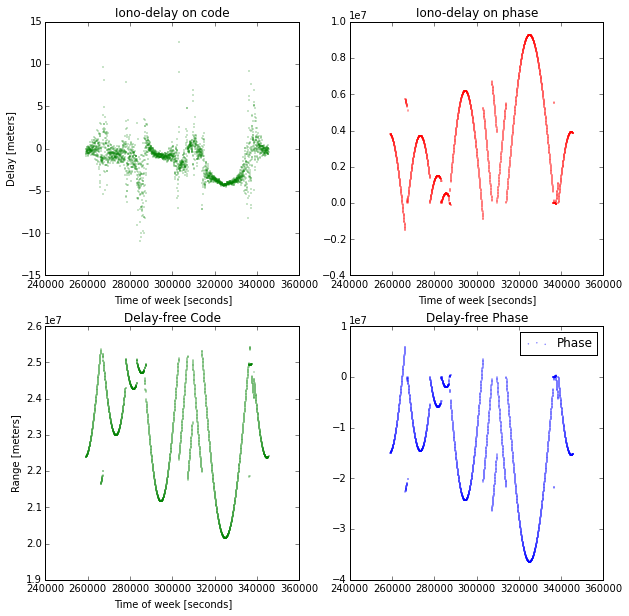

In [430]:
nfiles=[]
ofiles=[]

for i in range(1,8):
    n="/mnt/flin00"+str(i)+"0.09n"
    o="/mnt/flin00"+str(i)+"0.09o"
    nfiles.append(n)
    ofiles.append(o)
    

p,l,to,Idc,Idp=compute_ionodelay(nfiles,ofiles)
print "Canada 2009"
plot_delay(p,l,to,Idc,Idp)

Canada 2014


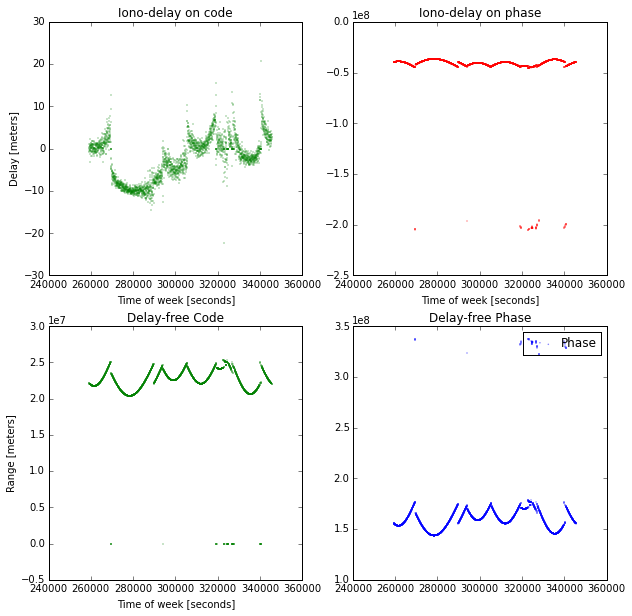

In [99]:
nfiles=[]
ofiles=[]

for i in range(121,128):
    n="/mnt/flin"+str(i)+"0.14n"
    o="/mnt/flin"+str(i)+"0.14o"
    nfiles.append(n)
    ofiles.append(o)
print "Canada 2014"
p,l,to,Idc,Idp=compute_ionodelay(nfiles,ofiles)
plot_delay(p,l,to,Idc,Idp)

Madrid 2009


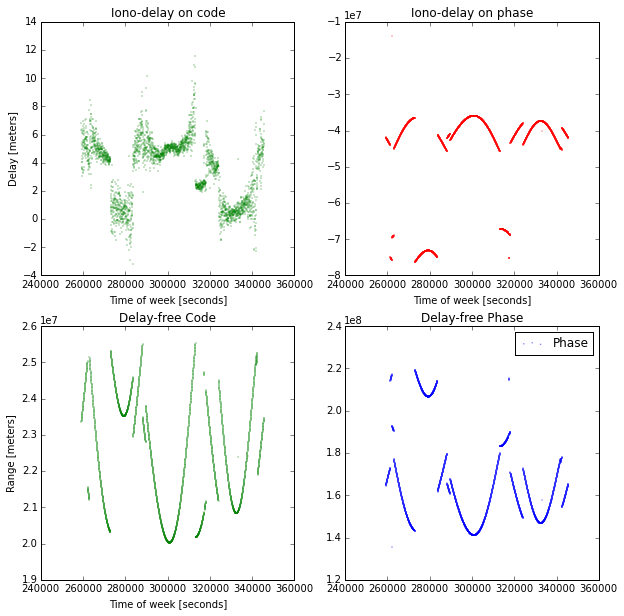

In [432]:
nfiles=[]
ofiles=[]

for i in range(1,8):
    n="/mnt/madr00"+str(i)+"0.09n"
    o="/mnt/madr00"+str(i)+"0.09o"
    nfiles.append(n)
    ofiles.append(o)

p,l,to,Idc,Idp=compute_ionodelay(nfiles,ofiles)
print "Madrid 2009"
plot_delay(p,l,to,Idc,Idp)

Madrid 2014


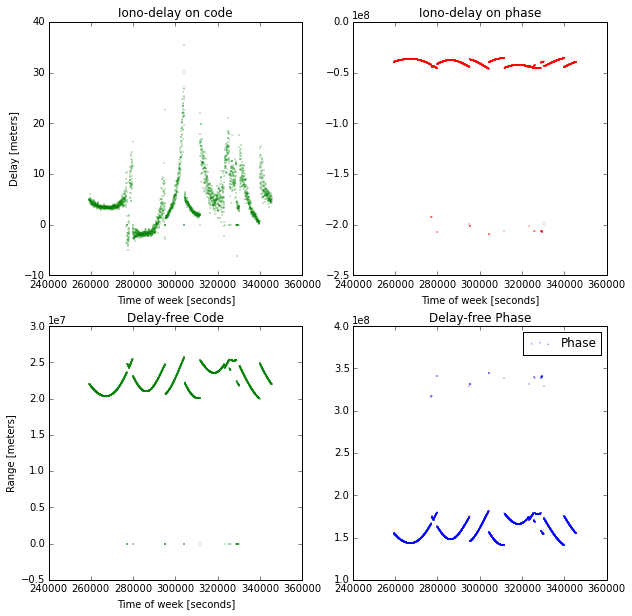

In [433]:
nfiles=[]
ofiles=[]

for i in range(121,128):
    n="/mnt/madr"+str(i)+"0.14n"
    o="/mnt/madr"+str(i)+"0.14o"
    nfiles.append(n)
    ofiles.append(o)
print "Madrid 2014"
p,l,to,Idc,Idp=compute_ionodelay(nfiles,ofiles)
plot_delay(p,l,to,Idc,Idp)

Galapagos 2009


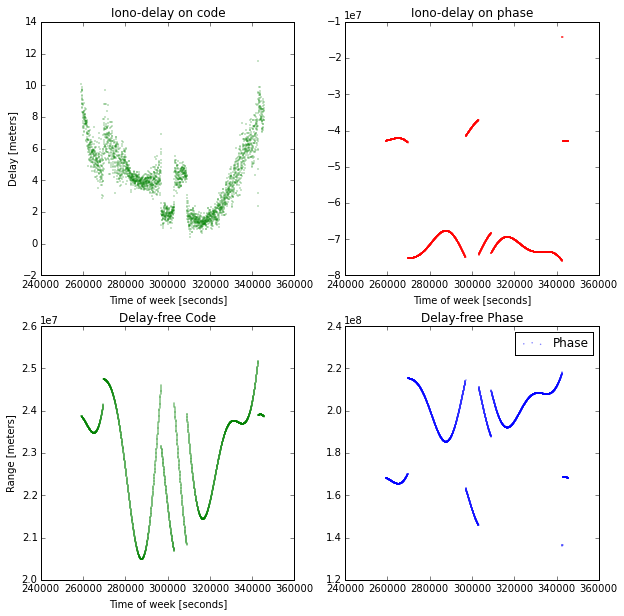

In [102]:
nfiles=[]
ofiles=[]

for i in range(1,8):
    n="/mnt/glps00"+str(i)+"0.09n"
    o="/mnt/glps00"+str(i)+"0.09o"
    nfiles.append(n)
    ofiles.append(o)

p,l,to,Idc,Idp=compute_ionodelay(nfiles,ofiles)
print "Galapagos 2009"
plot_delay(p,l,to,Idc,Idp)

Galapagos 2014


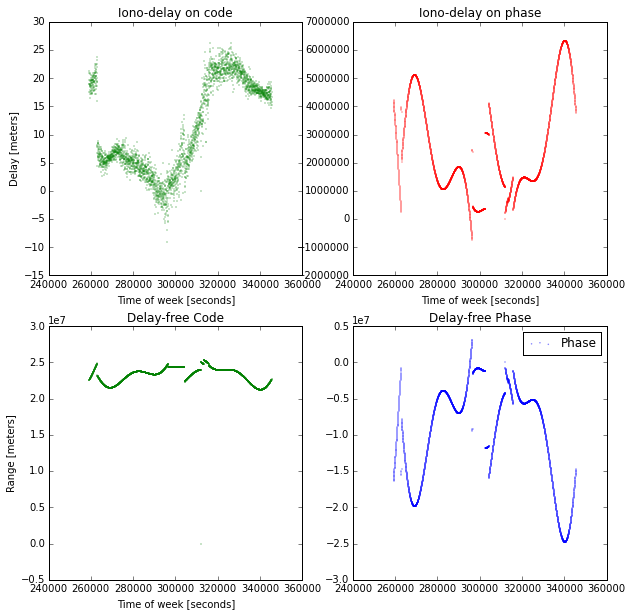

In [434]:
nfiles=[]
ofiles=[]

for i in range(121,128):
    n="/mnt/glps"+str(i)+"0.14n"
    o="/mnt/glps"+str(i)+"0.14o"
    nfiles.append(n)
    ofiles.append(o)
print "Galapagos 2014"
p,l,to,Idc,Idp=compute_ionodelay(nfiles,ofiles)
plot_delay(p,l,to,Idc,Idp)

#8). Same stations, plot iono delay predicted by Klobuchar from L1.


It is assumed that the electron content is concentrated in a thin layer at kilometres in height. Thence, the slant delay is computed from the vertical delay at the Ionospheric Pierce Point (IPP) multiplying by a obliquity factor (taken from <a href="http://www.navipedia.net/index.php/Klobuchar_Ionospheric_Model">here</a>)

In [435]:
import numpy as np
import gpstk
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

def klobuchar(obs,nav):
    ohead,odata=gpstk.readRinex3Obs(obs)
    nhead,ndata=gpstk.readRinex3Nav(nav)
    n=gpstk.readRinexNav(nav) #from this nav header we get klobuchar coeficients
    times=[] #times observed
    d=[]#iono delay
    
    bcestore = gpstk.GPSEphemerisStore() 
    for ndato in ndata:
        ephem = ndato.toGPSEphemeris()
        bcestore.addEphemeris(ephem)
    bcestore.SearchNear() 
    
    for observation in odata:
        sat=[satID for satID,datumList in observation.obs.iteritems()]
        if len(sat)!=0:
            sat=sat[0]
            eph = bcestore.findEphemeris(sat, observation.time) 
            sat_pos = eph.svXvt(observation.time)  
            elev = ohead.antennaPosition.elvAngle(sat_pos.x)# elevation and azimut are measured in degrees
            azim = ohead.antennaPosition.azAngle(sat_pos.x)
            razim=azim*np.pi/180 #azimut to radians
            relev=elev/180 #elevation in semicircles
            rec_pos = gpstk.Position(ohead.antennaPosition[0], ohead.antennaPosition[1], ohead.antennaPosition[2])
            geodetic_lat= rec_pos.geodeticLatitude()
            longitude=rec_pos.getLongitude()
            alpha=n[0].ionAlpha #Klobuchar's alpha & beta
            beta=n[0].ionBeta
            ec_angle=0.0137/(relev+0.11)  - 0.022 #earth centered angle
            sgeodetic_lat=geodetic_lat/180 #geodetic latitude in semicircles
            ipp_lat=sgeodetic_lat+ec_angle*np.cos(razim)
            if ipp_lat>0.416:
                ipp_lat=0.416
            elif ipp_lat<-0.416:
                ipp_lat=-0.416
            slongitude=longitude/180 #longitude in semicircles
            ipp_long=slongitude+((ec_angle*np.sin(razim))/(np.cos(ipp_lat)))
            ipp_geomaglat=ipp_lat+0.064*np.cos(ipp_long-1.617)

            t=43200*ipp_long+gpstk.GPSWeekSecond(observation.time).sow 
            if t>=86400:
                t-=86400
            if t<0:
                t+=86400

            AI=0
            for i in range(len(alpha)):
                AI=AI+(alpha[i]*ipp_geomaglat**i) #Amplitude of ionospheric delay
            if AI<0:
                AI=0

            PI=0
            for i in range(len(beta)):
                PI=PI+(beta[i]*ipp_geomaglat**i) #Period of ionospheric delay
            if PI<72000:
                PI=72000

            XI=2*np.pi*(t-50400)/PI    #Phase iono-delay
            F=1.0+16.0*(0.53-relev)**3 #Slant factor
            g = lambda x: alpha[x]*(ipp_geomaglat**x)*(1-(XI**2/2)+(XI**4/24))

            #Ionospheric time delay
            if np.abs(XI)<=1.57:
                IL1=5.10e-9+np.sum([g(i) for i in range(len(alpha)) ])*F
            else:
                IL1=5.10e-9*F

            dIon=299792458*IL1
            d.append(dIon)
            times.append(gpstk.GPSWeekSecond(observation.time).sow)
    return times,d
            

Delay in a day, one satellite


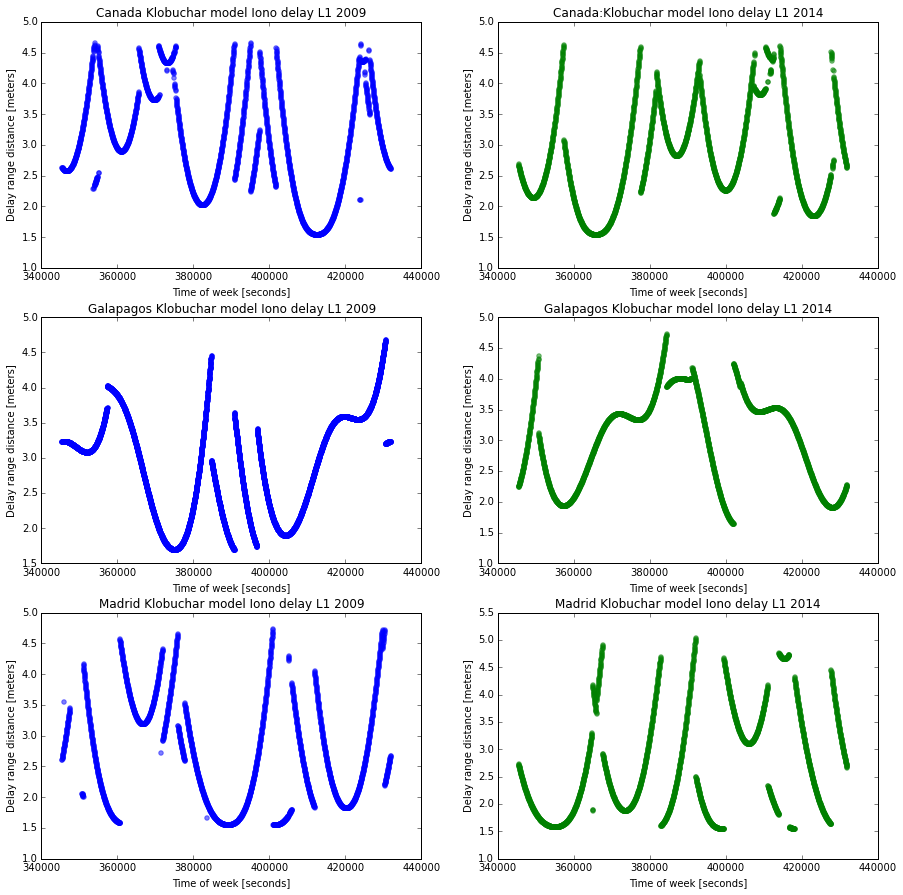

In [436]:
plt.figure(figsize=(15,15))
print "Delay in a day, one satellite"

obs="/mnt/flin0010.09o"
nav="/mnt/flin0010.09n"
t,d=klobuchar(obs,nav)
plt.subplot(3,2,1)
title="Canada Klobuchar model Iono delay L1 2009"
plt.title(title)
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="blue",alpha=.5)

obs="/mnt/flin1210.14o"
nav="/mnt/flin1210.14n"
t,d=klobuchar(obs,nav)
plt.subplot(3,2,2)
title="Canada:Klobuchar model Iono delay L1 2014 "
plt.title(title)
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="green",alpha=0.5)

obs="/mnt/glps0010.09o"
nav="/mnt/glps0010.09n"
t,d=klobuchar(obs,nav)
plt.subplot(3,2,3)
plt.title("Galapagos Klobuchar model Iono delay L1 2009")
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="blue")

obs="/mnt/glps1210.14o"
nav="/mnt/glps1210.14n"
t,d=klobuchar(obs,nav)
plt.subplot(3,2,4)
plt.title("Galapagos Klobuchar model Iono delay L1 2014")
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="green",alpha=.5)

obs="/mnt/madr0010.09o"
nav="/mnt/madr0010.09n"
t,d=klobuchar(obs,nav)
plt.subplot(3,2,5)
plt.title("Madrid Klobuchar model Iono delay L1 2009")
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="blue",alpha=.5)

obs="/mnt/madr1210.14o"
nav="/mnt/madr1210.14n"
t,d=klobuchar(obs,nav)
plt.subplot(3,2,6)
plt.title("Madrid Klobuchar model Iono delay L1 2014")
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="green",alpha=.5)





##Comparing double frequency and klobuchar model on a day

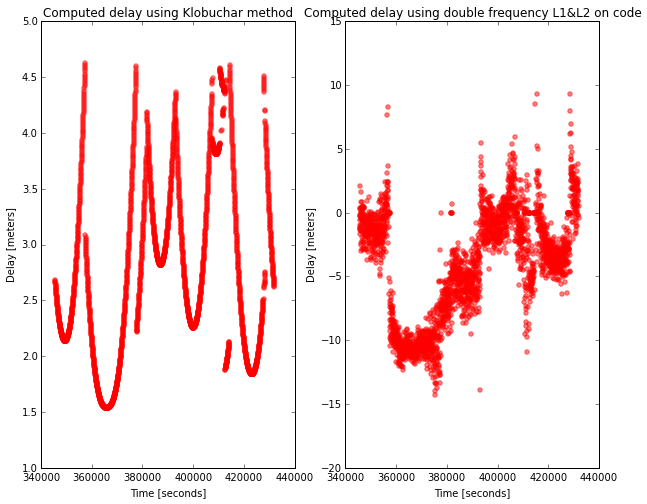

In [426]:
obs="data2/flin1210.14o"
nav="data2/flin1210.14n"
kt,kd=klobuchar(obs,nav)
_,_,to,Id_code,Id_phase=compute_ionodelay([nav],[obs])
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.title("Computed delay using Klobuchar method")
plt.xlabel("Time [seconds]")
plt.ylabel("Delay [meters]")
plt.scatter(kt,kd,color="red",alpha=0.5)


plt.subplot(1,2,2)
plt.title("Computed delay using double frequency L1&L2 on code")
plt.xlabel("Time [seconds]")
plt.ylabel("Delay [meters]")
plt.scatter(to,Id_code,color="red",alpha=0.5)


#9). Download CORS data according to Susana's presentation and compute iono gradients using dual frequency station pairwise.